# 3 classic ML algorithms
## 2.Polynomial regression

[deg=1, scale=True, intercept=True]  MSE = 0.1786
[deg=1, scale=True, intercept=False]  MSE = 0.1786
[deg=1, scale=False, intercept=True]  MSE = 0.1786
[deg=1, scale=False, intercept=False]  MSE = 0.1779
[deg=2, scale=True, intercept=True]  MSE = 0.3003
[deg=2, scale=True, intercept=False]  MSE = 0.3003
[deg=2, scale=False, intercept=True]  MSE = 0.2950
[deg=2, scale=False, intercept=False]  MSE = 0.2951
[deg=3, scale=True, intercept=True]  MSE = 0.4754
[deg=3, scale=True, intercept=False]  MSE = 0.4754
[deg=3, scale=False, intercept=True]  MSE = 0.5184
[deg=3, scale=False, intercept=False]  MSE = 0.5164

 BEST CONFIGURATION
{'degree': 1, 'scale_features': False, 'fit_intercept': False, 'mse': 0.1778540308248925, 'poly': PolynomialFeatures(degree=1, include_bias=False), 'model': LinearRegression(fit_intercept=False), 'scaler_poly': None}

All results sorted by MSE:
   degree  scale_features  fit_intercept       mse
3       1           False          False  0.177854
2       1           

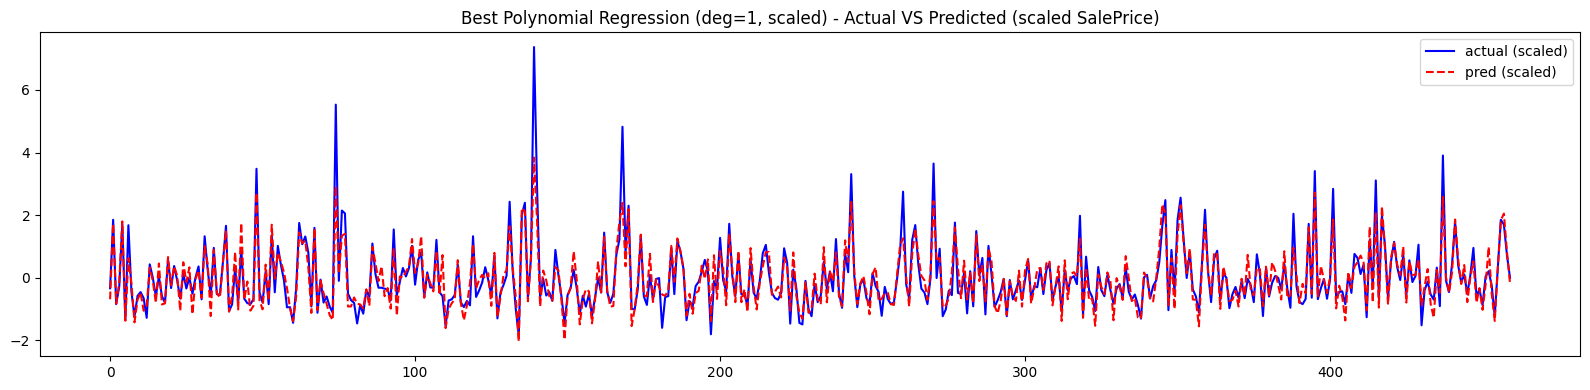

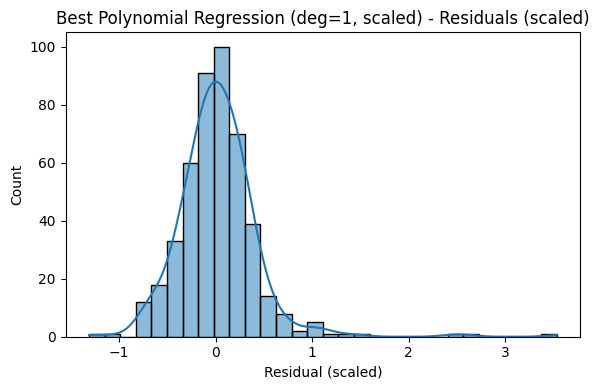

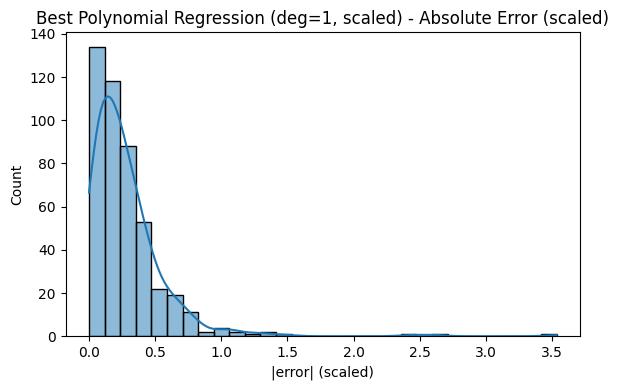

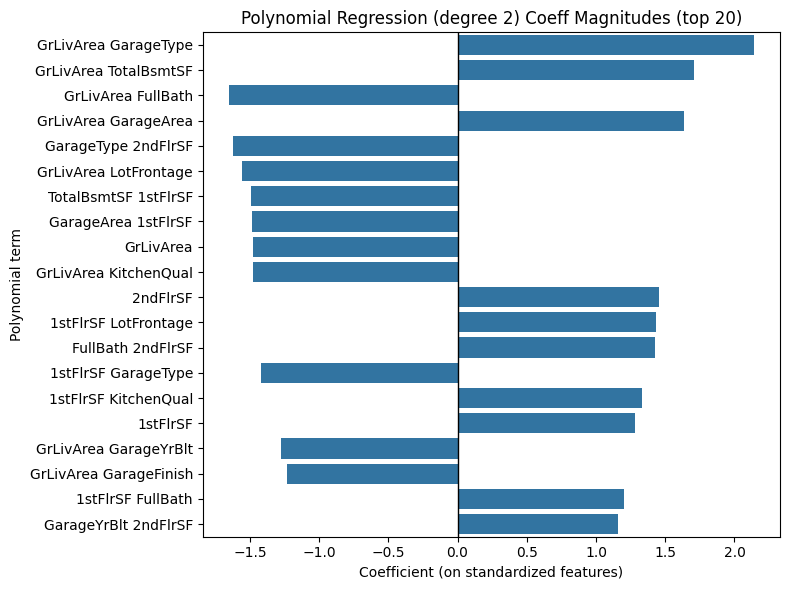

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

CSV_PATH = "train.csv"


def preprocess_and_split_li2023(csv_path=CSV_PATH, top_k=30, random_state=42):
    df_house = pd.read_csv(csv_path)

    drop_cols = [
        "Alley", "YearRemodAdd", "FireplaceQu", "PoolQC",
        "Fence", "MasVnrType", "MiscFeature", "Id"
    ]
    df_house = df_house.drop(columns=[c for c in drop_cols if c in df_house.columns])

    target = "SalePrice"
    y = df_house[target]
    X = df_house.drop(columns=[target])

    num_cols = X.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = X.select_dtypes(include=["object"]).columns

    X[num_cols] = X[num_cols].apply(lambda col: col.fillna(col.mean()))
    X[cat_cols] = X[cat_cols].fillna("NONE")

    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    if len(cat_cols) > 0:
        X[cat_cols] = encoder.fit_transform(X[cat_cols])

    scaler_x = StandardScaler()
    X_scaled_arr = scaler_x.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_arr, columns=X.columns)
    X_scaled[target] = y.values

    corr = X_scaled.corr()[target].drop(target)
    corr_sorted = corr.abs().sort_values(ascending=False)
    top_features = corr_sorted.index[:top_k].tolist()

    X_final = X_scaled[top_features]
    y_final = y.copy()

    test_size = 460 / len(X_final)
    X_train, X_test, y_train, y_test = train_test_split(
        X_final,
        y_final,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
    )

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "top_features": top_features,
    }


def tune_polynomial_regression(X_train, X_test, y_train_scaled, y_test_scaled):
    degrees = [1, 2, 3]
    fit_intercepts = [True, False]
    scale_poly_options = [True, False]

    best_cfg = None
    best_mse = float("inf")

    all_results = []

    for deg in degrees:
        poly = PolynomialFeatures(degree=deg, include_bias=False)

        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        for scale_poly in scale_poly_options:
            if scale_poly:
                scaler_poly = StandardScaler()
                X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
                X_test_poly_scaled = scaler_poly.transform(X_test_poly)
            else:
                X_train_poly_scaled = X_train_poly
                X_test_poly_scaled = X_test_poly

            for fit_int in fit_intercepts:
                model = LinearRegression(fit_intercept=fit_int)
                model.fit(X_train_poly_scaled, y_train_scaled)

                pred_scaled = model.predict(X_test_poly_scaled)
                mse = mean_squared_error(y_test_scaled, pred_scaled)

                all_results.append(
                    {
                        "degree": deg,
                        "scale_features": scale_poly,
                        "fit_intercept": fit_int,
                        "mse": mse,
                    }
                )

                if mse < best_mse:
                    best_mse = mse
                    best_cfg = {
                        "degree": deg,
                        "scale_features": scale_poly,
                        "fit_intercept": fit_int,
                        "mse": mse,
                        "poly": poly,
                        "model": model,
                        "scaler_poly": scaler_poly if scale_poly else None,
                    }

                print(f"[deg={deg}, scale={scale_poly}, intercept={fit_int}]  MSE = {mse:.4f}")

    print("\n===================")
    print(" BEST CONFIGURATION")
    print("===================")
    print(best_cfg)

    results_df = pd.DataFrame(all_results)
    return best_cfg, results_df


def evaluate_and_plot_scaled(name, y_true_scaled, y_pred_scaled):
    mse = mean_squared_error(y_true_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_true_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)

    print(f"\n=== {name} (SCALED target) ===")
    print("MSE:  %.4f" % mse)
    print("MAE:  %.4f" % mae)
    print("RMSE: %.4f" % rmse)

    plt.figure(figsize=(16, 4))
    plt.plot(y_true_scaled, label="actual (scaled)", color="blue")
    plt.plot(y_pred_scaled, label="pred (scaled)", color="red", linestyle="--")
    plt.title(f"{name} - Actual VS Predicted (scaled SalePrice)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    residuals = y_true_scaled - y_pred_scaled
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{name} - Residuals (scaled)")
    plt.xlabel("Residual (scaled)")
    plt.tight_layout()
    plt.show()

    abs_err = np.abs(residuals)
    plt.figure(figsize=(6, 4))
    sns.histplot(abs_err, bins=30, kde=True)
    plt.title(f"{name} - Absolute Error (scaled)")
    plt.xlabel("|error| (scaled)")
    plt.tight_layout()
    plt.show()


def plot_poly_feature_importances(
    model,
    poly,
    base_feature_names,
    top_n=20,
    title="Polynomial Regression Coeff Magnitudes",
):
    poly_names = poly.get_feature_names_out(base_feature_names)
    coefs = model.coef_
    abs_coefs = np.abs(coefs)

    idx_sorted = np.argsort(abs_coefs)[::-1][:top_n]
    names_sorted = [poly_names[i] for i in idx_sorted]
    coefs_sorted = coefs[idx_sorted]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=coefs_sorted, y=names_sorted)
    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"{title} (top {top_n})")
    plt.xlabel("Coefficient (on standardized features)")
    plt.ylabel("Polynomial term")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    data = preprocess_and_split_li2023(CSV_PATH, top_k=30, random_state=42)

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train_scaled = data["y_train_scaled"]
    y_test_scaled = data["y_test_scaled"]

    best_cfg, df_results = tune_polynomial_regression(
        X_train,
        X_test,
        y_train_scaled,
        y_test_scaled,
    )

    print("\nAll results sorted by MSE:")
    print(df_results.sort_values("mse").head())

    best_poly = best_cfg["poly"]
    best_model = best_cfg["model"]
    best_scaler_poly = best_cfg["scaler_poly"]

    X_test_poly = best_poly.transform(X_test)
    if best_scaler_poly is not None:
        X_test_poly = best_scaler_poly.transform(X_test_poly)

    best_pred_scaled = best_model.predict(X_test_poly)
    evaluate_and_plot_scaled(
        f"Best Polynomial Regression (deg={best_cfg['degree']}, scaled)",
        y_test_scaled,
        best_pred_scaled,
    )

    plot_poly_feature_importances(
        poly_reg, poly,
        base_feature_names=X_train.columns.tolist(),
        top_n=20,
        title=f"Polynomial Regression (degree {degree}) Coeff Magnitudes"
    )
